# Mulai

In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RisetHibahPemerintah/data_fix.csv')

In [ ]:
df.head(2)

,topik,Answer,Year,Answer_fix
0,adhd,alo selamat siang dari penjelasan anda anda me...,2024,"['susah', 'fokus', 'susah', 'fokus', 'tanda', ..."
1,adhd,alo terimakasih atas pertanyaannya adhd sering...,2024,"['adhd', 'gejala', 'kisar', 'usia', 'gejala', ..."


In [ ]:
df['Answer_fix'] = df['Answer_fix'].apply(eval)

# Import Pustaka

In [ ]:
!pip install pyLDAvis
!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 42.0 MB/s eta 0:00:00


In [ ]:
# Import pustaka yang diperlukan
import pandas as pd
import numpy as np
import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from gensim.models import Phrases
from gensim.models.phrases import Phraser
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import nltk
from nltk import bigrams
from collections import Counter


# Ekstraksi Fitur

In [ ]:
texts = df['Answer_fix'].tolist()

### membuat kolom bigram

In [ ]:
# Membuat kolom baru untuk bigram tanpa pasangan kata yang sama
df['Bigrams'] = df['Answer_fix'].apply(lambda x: [bigram for bigram in bigrams(x) if bigram[0] != bigram[1]])

# Menggabungkan semua bigram ke dalam satu list
all_bigrams = [bigram for sublist in df['Bigrams'] for bigram in sublist]

# Menghitung frekuensi bigram
bigram_freq = Counter(all_bigrams)

# Menampilkan bigram yang paling umum
most_common_bigrams = bigram_freq.most_common(10)
most_common_bigrams

[(('ganggu', 'cemas'), 6829),
 (('dokter', 'spesialis'), 4827),
 (('ganggu', 'jiwa'), 4629),
 (('ganggu', 'mental'), 4440),
 (('konsultasi', 'dokter'), 3950),
 (('ganggu', 'pribadi'), 3788),
 (('alami', 'ganggu'), 3550),
 (('periksa', 'dokter'), 3506),
 (('depresi', 'ganggu'), 3453),
 (('dokter', 'psikiater'), 3133)]

In [ ]:
print("panjang bigram 1:",len(bigram_freq))

panjang bigram 1: 211349


In [ ]:
df[['Answer_fix','Bigrams']].head()

,Answer_fix,Bigrams
0,"[susah, fokus, susah, fokus, tanda, alami, adh...","[(susah, fokus), (fokus, susah), (susah, fokus..."
1,"[adhd, gejala, kisar, usia, gejala, adhd, taha...","[(adhd, gejala), (gejala, kisar), (kisar, usia..."
2,"[cemas, gugup, tegang, sulit, konsentrasi, mud...","[(cemas, gugup), (gugup, tegang), (tegang, sul..."
3,"[mudah, gelisah, sulit, fokus, tanda, alami, a...","[(mudah, gelisah), (gelisah, sulit), (sulit, f..."
4,"[adhd, attention, deficit, hyperactivity, diso...","[(adhd, attention), (attention, deficit), (def..."


## filter bigram

In [ ]:
# Menentukan batas frekuensi minimal
min_freq = 5

# Menyaring bigram berdasarkan batas frekuensi minimal
filtered_bigrams = {bigram: freq for bigram, freq in bigram_freq.items() if freq >= min_freq}

# Menyimpan bigram yang memenuhi syarat ke dalam kolom baru
df['Bigrams'] = df['Bigrams'].apply(lambda x: [bigram for bigram in x if bigram in filtered_bigrams])

In [ ]:
df[['Answer_fix','Bigrams']].head()

,Answer_fix,Bigrams
0,"[susah, fokus, susah, fokus, tanda, alami, adh...","[(susah, fokus), (susah, fokus), (fokus, tanda..."
1,"[adhd, gejala, kisar, usia, gejala, adhd, taha...","[(adhd, gejala), (kisar, usia), (usia, gejala)..."
2,"[cemas, gugup, tegang, sulit, konsentrasi, mud...","[(cemas, gugup), (gugup, tegang), (tegang, sul..."
3,"[mudah, gelisah, sulit, fokus, tanda, alami, a...","[(mudah, gelisah), (gelisah, sulit), (sulit, f..."
4,"[adhd, attention, deficit, hyperactivity, diso...","[(adhd, attention), (attention, deficit), (def..."


In [ ]:
print("panjang bigram 3:",len(filtered_bigrams))

panjang bigram 3: 42984


## bigram ke bentuk tuple kata

In [ ]:
# Mengubah bigram ke dalam bentuk tuple kata
df['Bigrams'] = df['Bigrams'].apply(lambda bigrams: ['_'.join(bigram) for bigram in bigrams])

In [ ]:
df[['Answer_fix','Bigrams']].head()

,Answer_fix,Bigrams
0,"[susah, fokus, susah, fokus, tanda, alami, adh...","[susah_fokus, susah_fokus, fokus_tanda, tanda_..."
1,"[adhd, gejala, kisar, usia, gejala, adhd, taha...","[adhd_gejala, kisar_usia, usia_gejala, gejala_..."
2,"[cemas, gugup, tegang, sulit, konsentrasi, mud...","[cemas_gugup, gugup_tegang, tegang_sulit, suli..."
3,"[mudah, gelisah, sulit, fokus, tanda, alami, a...","[mudah_gelisah, gelisah_sulit, sulit_fokus, fo..."
4,"[adhd, attention, deficit, hyperactivity, diso...","[adhd_attention, attention_deficit, deficit_hy..."


## membuat dictionary dan corpus

In [ ]:
texts = df['Bigrams'].tolist()

# membuat dictionary dan corpus
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

## simpan ekstraksi fitur ke file

In [ ]:
import pickle

In [ ]:
# Menentukan path
path = '/content/drive/MyDrive/Colab Notebooks/RisetHibahPemerintah/pickle data/'

In [ ]:
# Menyimpan texts ke file
with open(f'{path}texts3_00.pkl', 'wb') as f:
    pickle.dump(texts, f)

# Menyimpan dictionary ke file
dictionary.save(f'{path}dictionary3_00.gensim')

# Menyimpan corpus ke file
with open(f'{path}corpus3_00.pkl', 'wb') as f:
    pickle.dump(corpus, f)

In [ ]:
# # Memuat texts dari file
# with open(f'{path}texts3_00.pkl', 'rb') as f:
#     texts = pickle.load(f)

# # Memuat dictionary dari file
# dictionary = corpora.Dictionary.load(f'{path}dictionary3_00.gensim')

# # Memuat corpus dari file
# with open(f'{path}corpus3_00.pkl', 'rb') as f:
#     corpus = pickle.load(f)

# Membangun topik model

## Mencari coherence values optimal

In [ ]:
from tqdm import tqdm

def build_lda_models(dictionary, corpus, start, limit, step, random_state=100, update_every=1, chunksize=100, passes=1, iterations=50, alpha='symmetric', eta='symmetric', per_word_topics=True):
    model_list = []
    # Menggunakan tqdm untuk progress bar pada range
    for num_topics in tqdm(range(start, limit, step), desc="Membangun Model"):
        model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=random_state,
                         update_every=update_every,
                         chunksize=chunksize,
                         passes=passes,
                         iterations=iterations,
                         alpha=alpha,
                         eta=eta,
                         per_word_topics=per_word_topics)
        model_list.append(model)
    return model_list

In [ ]:
# Menjalankan fungsi untuk membuat model
model_list = build_lda_models(dictionary=dictionary, corpus=corpus, start=2, limit=50, step=1)

# Menyimpan model_list ke file
with open(f'{path}model_list3_00.pkl', 'wb') as f:
    pickle.dump(model_list, f)

Membangun Model: 100%|██████████| 48/48 [18:13<00:00, 22.78s/it]


In [ ]:
from tqdm import tqdm

def get_coherence_values(model_list, dictionary, texts):
    coherence_values = []
    for model in tqdm(model_list, desc="Calculating Coherence"):
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return coherence_values

In [ ]:
# Menjalankan fungsi untuk mendapatkan nilai coherence model
coherence_values = get_coherence_values(model_list=model_list, dictionary=dictionary, texts=texts)

# Menyimpan coherence_values ke file
with open(f'{path}coherence_values3_00.pkl', 'wb') as f:
    pickle.dump(coherence_values, f)

Calculating Coherence: 100%|██████████| 48/48 [04:01<00:00,  5.02s/it]


In [ ]:
# # Memuat kembali data file pickle
# with open(f'{path}model_list3_00.pkl', 'rb') as f:
#     model_list = pickle.load(f)

# with open(f'{path}coherence_values3_00.pkl', 'rb') as f:
#     coherence_values = pickle.load(f)

## hasil iterasi

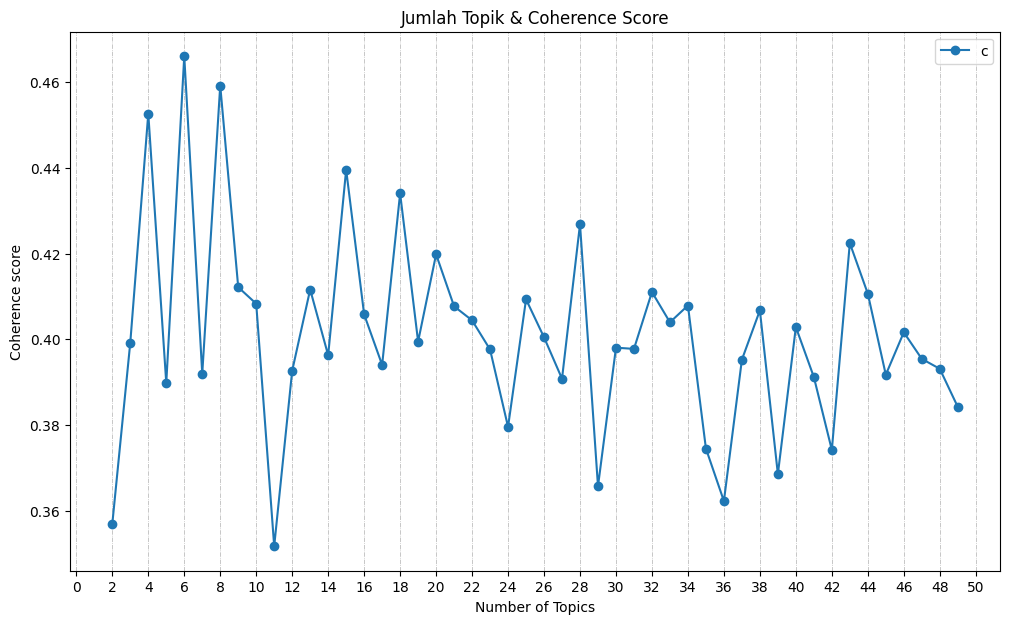

In [ ]:
# Menampilkan grafik coherence score
limit=50; start=2; step=1;
x = range(start, limit, step)

# Membuat plot
plt.figure(figsize=(12, 7))  # Mengatur ukuran grafik memanjang ke samping
plt.plot(x, coherence_values, marker='o')  # Menambahkan marker untuk setiap titik

# Menyesuaikan skala label di sumbu x
plt.xticks(range(1, limit, 2))

# menambahkan garis background
plt.grid(True, axis='x', linestyle='-.', linewidth=0.5)

# Menyesuaikan interval grid pada sumbu x
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(2))

plt.title("Jumlah Topik & Coherence Score")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Mencetak nilai coherence score
for m, cv in zip(x, coherence_values):
    print(f"Num Topics = {m} has Coherence Value of {cv}")

Num Topics = 2 has Coherence Value of 0.35696528437778047
Num Topics = 3 has Coherence Value of 0.3992509463969494
Num Topics = 4 has Coherence Value of 0.45261892807734133
Num Topics = 5 has Coherence Value of 0.3897984900414936
Num Topics = 6 has Coherence Value of 0.4660044463605764
Num Topics = 7 has Coherence Value of 0.3919627957224849
Num Topics = 8 has Coherence Value of 0.45917410945702475
Num Topics = 9 has Coherence Value of 0.41214372384635733
Num Topics = 10 has Coherence Value of 0.40829855808055415
Num Topics = 11 has Coherence Value of 0.3517475669789128
Num Topics = 12 has Coherence Value of 0.3926621523546467
Num Topics = 13 has Coherence Value of 0.4115999783267762
Num Topics = 14 has Coherence Value of 0.396282047073994
Num Topics = 15 has Coherence Value of 0.4395528148117985
Num Topics = 16 has Coherence Value of 0.4057978115138423
Num Topics = 17 has Coherence Value of 0.39403176333010537
Num Topics = 18 has Coherence Value of 0.43402946635408146
Num Topics = 19 

In [ ]:
# Menentukan jumlah topik optimal berdasarkan coherence value terbaik
max_coherence = max(coherence_values)
print(f"Nilai coherence tertinggi: {max_coherence}")
optimal_num_topics = x[coherence_values.index(max(coherence_values))]
print(f"Jumlah topik yang memberikan nilai coherence tertinggi: {optimal_num_topics}")

Nilai coherence tertinggi: 0.4660044463605764
Jumlah topik yang memberikan nilai coherence tertinggi: 6


In [ ]:
# Mengambil model optimal dengan nilai coherence tertinggi
optimal_index = coherence_values.index(max(coherence_values))
optimal_model = model_list[optimal_index]

## metode input manual jumlah topik

In [ ]:
# optimal_num_topics = 5
# optimal_num_topics

In [ ]:
# # Membangun model LDA dengan jumlah topik optimal dan pengaturan tambahan untuk meningkatkan akurasi
# optimal_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
#                                                 id2word=dictionary,
#                                                 num_topics=optimal_num_topics,
#                                                 random_state=100,
#                                                 update_every=1,
#                                                 chunksize=100,
#                                                 passes=1,
#                                                 iterations=50,
#                                                 alpha='symmetric',
#                                                 eta='symmetric',
#                                                 per_word_topics=True)

## hasil model

In [ ]:
# Menyimpan model ke file pickle
with open(f'{path}lda_bigram_model.pkl', 'wb') as f:
    pickle.dump(optimal_model, f)

In [ ]:
# # Menghitung nilai coherence dari model optimal
# coherence_model_lda = CoherenceModel(model=optimal_model, texts=texts, dictionary=dictionary, coherence='c_v')
# coherence_lda = coherence_model_lda.get_coherence()

# # Menampilkan nilai coherence
# print(f"Coherence Score: {coherence_lda}")

In [ ]:
# Menampilkan topik dengan pprint
from pprint import pprint
pprint(optimal_model.print_topics())

[(0,
  '0.021*"berat_badan" + 0.008*"dokter_kandung" + 0.006*"sakit_kepala" + '
  '0.006*"hasil_periksa" + 0.005*"badan_ideal" + 0.004*"jaga_berat" + '
  '0.004*"turun_berat" + 0.004*"periksa_langsung" + 0.003*"lelah_fisik" + '
  '0.003*"periksa_dokter"'),
 (1,
  '0.041*"cabut_rambut" + 0.022*"ganggu_mental" + 0.013*"kulit_kepala" + '
  '0.006*"stres_psikis" + 0.006*"sekian_informasi" + 0.005*"rambut_kepala" + '
  '0.005*"derita_trikotilomania" + 0.005*"alami_ganggu" + 0.004*"dokter_kulit" '
  '+ 0.004*"psikolog_psikiater"'),
 (2,
  '0.016*"sehat_mental" + 0.014*"ganggu_sehat" + 0.012*"dokter_spesialis" + '
  '0.011*"langsung_dokter" + 0.007*"spesialis_psikiatri" + '
  '0.006*"stres_psikologis" + 0.006*"paham_khawatir" + 0.006*"periksa_tunjang" '
  '+ 0.005*"konsultasi_langsung" + 0.005*"kendali_impuls"'),
 (3,
  '0.006*"nafsu_makan" + 0.006*"ganggu_jiwa" + 0.005*"nyeri_dada" + '
  '0.005*"depresi_ganggu" + 0.005*"ganggu_cemas" + 0.005*"dokter_psikiater" + '
  '0.004*"ganggu_hormonal" 

In [ ]:
# Hanya memuat 20 kata teratas
topics = [[(term, round(wt, 3)) for term, wt in optimal_model.show_topic(n, topn=30)] for n in range(0, optimal_model.num_topics)]

# # Mendefinisikan seluruh corpus dari topik-topik dalam model LDA
# topics = [[(term, round(wt, 3)) for term, wt in optimal_model.show_topic(n, topn=None)] for n in range(optimal_model.num_topics)]

len(topics)

6

In [ ]:
# Membuat DataFrame untuk Topic-Term
topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics], columns=['Term'+str(i) for i in range(1, 31)], index=['Topic '+str(t) for t in range(1, optimal_model.num_topics+1)]).T

# # Membuat DataFrame untuk seluruh Topic-Term
# topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics],
#                          columns=['Term'+str(i) for i in range(1, len(topics[0])+1)],
#                          index=['Topic '+str(t) for t in range(1, optimal_model.num_topics+1)]).T

topics_df

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6
Term1,berat_badan,cabut_rambut,sehat_mental,nafsu_makan,konsultasi_dokter,langsung_dokter
Term2,dokter_kandung,ganggu_mental,ganggu_sehat,ganggu_jiwa,dokter_spesialis,periksa_langsung
Term3,sakit_kepala,kulit_kepala,dokter_spesialis,nyeri_dada,periksa_dokter,ganggu_jiwa
Term4,hasil_periksa,stres_psikis,langsung_dokter,depresi_ganggu,ganggu_cemas,hidup_sehat
Term5,badan_ideal,sekian_informasi,spesialis_psikiatri,ganggu_cemas,konsumsi_makan,gaya_hidup
Term6,jaga_berat,rambut_kepala,stres_psikologis,dokter_psikiater,periksa_fisik,pasca_trauma
Term7,turun_berat,derita_trikotilomania,paham_khawatir,ganggu_hormonal,efek_samping,ganggu_stres
Term8,periksa_langsung,alami_ganggu,periksa_tunjang,hindar_rokok,olahraga_atur,periksa_dokter
Term9,lelah_fisik,dokter_kulit,konsultasi_langsung,serang_panik,konsumsi_obat,stres_pasca
Term10,periksa_dokter,psikolog_psikiater,kendali_impuls,sayur_buah,kondisi_alami,cari_solusi


In [ ]:
pd.set_option('display.max_colwidth', None)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns=['Terms per Topic'], index=['Topic'+str(t) for t in range(1, optimal_model.num_topics+1)])
topics_df

,Terms per Topic
Topic1,"berat_badan, dokter_kandung, sakit_kepala, hasil_periksa, badan_ideal, jaga_berat, turun_berat, periksa_langsung, lelah_fisik, periksa_dokter, organ_reproduksi, spesialis_kandung, nyeri_kepala, lambat_menstruasi, kandung_periksa, imbang_hormon, langsung_dokter, pola_hidup, konsultasi_langsung, kontrasepsi_hormonal, periksa_darah, stres_cemas, olah_raga, flek_coklat, rontok_rambut, tidur_larut, gantung_hasil, haid_atur, efek_samping, badan_drastis"
Topic2,"cabut_rambut, ganggu_mental, kulit_kepala, stres_psikis, sekian_informasi, rambut_kepala, derita_trikotilomania, alami_ganggu, dokter_kulit, psikolog_psikiater, mental_ganggu, infeksi_jamur, mental_derita, rumah_sakit, kondisi_trikotilomania, derita_alami, terapi_perilaku, tahan_cabut, rambut_ganggu, folikel_rambut, dorong_cabut, rambut_gatal, ganggu_fungsi, rambut_derita, derita_ganggu, suka_cabut, trikotilomania_ganggu, ubah_perilaku, periksa_psikiater, stres_fisik"
Topic3,"sehat_mental, ganggu_sehat, dokter_spesialis, langsung_dokter, spesialis_psikiatri, stres_psikologis, paham_khawatir, periksa_tunjang, konsultasi_langsung, kendali_impuls, obat_bantu, periksa_fisis, saran_konsultasi, post_traumatic, traumatic_stress, lelah_aktivitas, dokter_gejala, dokter_obat, sehat_manfaat, stress_disorder, informasi_manfaat, episode_depresi, gejala_alami, kait_sakit, relaksasi_napas, dokter_nilai, cerita_keluh, keluh_faktor, gizi_atur, paham_kondisi"
Topic4,"nafsu_makan, ganggu_jiwa, nyeri_dada, depresi_ganggu, ganggu_cemas, dokter_psikiater, ganggu_hormonal, hindar_rokok, serang_panik, sayur_buah, tidur_jam, suasana_hati, sulit_konsentrasi, kondisi_sehat, detak_jantung, jantung_debar, hilang_minat, ganggu_tidur, cemas_khawatir, ganggu_mental, asa_sedih, alami_depresi, faktor_genetik, putus_asa, beban_pikir, ganggu_panik, sesak_napas, mudah_lelah, sulit_tidur, tarik_napas"
Topic5,"konsultasi_dokter, dokter_spesialis, periksa_dokter, ganggu_cemas, konsumsi_makan, periksa_fisik, efek_samping, olahraga_atur, konsumsi_obat, kondisi_alami, tekan_darah, keluh_alami, kelola_stres, dokter_periksa, siklus_menstruasi, air_putih, periksa_tunjang, spesialis_jiwa, kondisi_medis, alami_ganggu, informasi_bantu, keluh_ganggu, kelola_stress, pola_hidup, siklus_haid, makan_gizi, samping_obat, cemas_ganggu, fisik_periksa, ganggu_aktivitas"
Topic6,"langsung_dokter, periksa_langsung, ganggu_jiwa, hidup_sehat, gaya_hidup, pasca_trauma, ganggu_stres, periksa_dokter, stres_pasca, cari_solusi, ganggu_imbang, minum_obat, dokter_psikiater, rokok_alkohol, depresi_ganggu, keluh_muncul, ganggu_pribadi, ganggu_cemas, trauma_ganggu, tidur_atur, makan_atur, imbang_hormonal, riwayat_periksa, ganggu_delusi, ganggu_bipolar, infeksi_virus, jalan_gaya, ganggu_skizoafektif, sembarang_minum, turun_drastis"


#visualisasi

In [ ]:
# Membuat WordCloud
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)
plt.rcParams['figure.figsize'] = [20, 15]

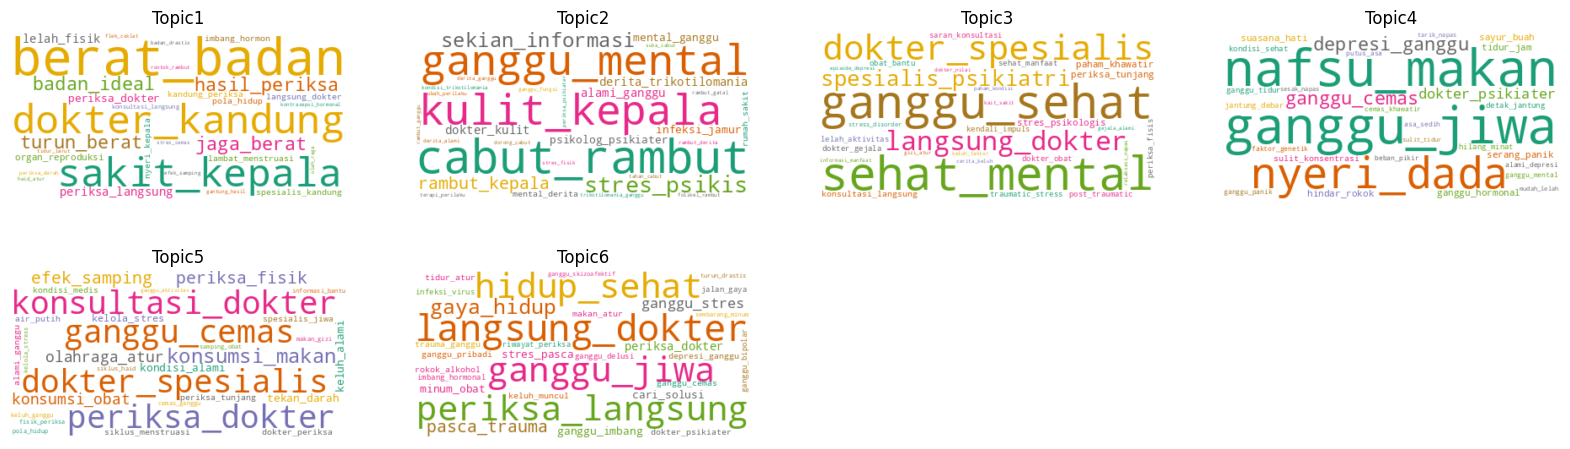

In [ ]:
# Membuat subgrafik untuk setiap topik
for i in range(optimal_model.num_topics):
    wc.generate(text=topics_df["Terms per Topic"][i])
    plt.subplot(5, 4, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df.index[i])

plt.show()

In [ ]:
# Menampilkan visualisasi interaktif dengan pyLDAvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(optimal_model, corpus, dictionary)
pyLDAvis.display(vis)

# Analisis

## Membuat dataframe corpus

In [ ]:
def format_topics_sentences(ldamodel, corpus, texts, num_words):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num, topn=num_words)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = pd.concat([sent_topics_df, pd.DataFrame([[int(topic_num), round(prop_topic, 4), topic_keywords]])], ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df

In [ ]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=texts, num_words=30)

In [ ]:
# Format dataframe
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [ ]:
# Create a dataframe to hold results
corpus_topic_df = pd.DataFrame()

# Get the Titles from the original dataframe
corpus_topic_df['row'] = df.index + 1
corpus_topic_df['topik'] = df.topik

# Add dominant topic and contribution to the dataframe
corpus_topic_df['Dominant Topic'] = df_dominant_topic['Dominant_Topic'] + 1
corpus_topic_df['Contribution %'] = df_dominant_topic['Topic_Perc_Contrib'] * 100
corpus_topic_df['Topic Terms'] = df_dominant_topic['Keywords']

In [ ]:
# Display the dataframe
corpus_topic_df.head()

,row,topik,Dominant Topic,Contribution %,Topic Terms
0,1,adhd,4,39.340000,"nafsu_makan, ganggu_jiwa, nyeri_dada, depresi_ganggu, ganggu_cemas, dokter_psikiater, ganggu_hormonal, hindar_rokok, serang_panik, sayur_buah, tidur_jam, suasana_hati, sulit_konsentrasi, kondisi_sehat, detak_jantung, jantung_debar, hilang_minat, ganggu_tidur, cemas_khawatir, ganggu_mental, asa_sedih, alami_depresi, faktor_genetik, putus_asa, beban_pikir, ganggu_panik, sesak_napas, mudah_lelah, sulit_tidur, tarik_napas"
1,2,adhd,2,73.239998,"cabut_rambut, ganggu_mental, kulit_kepala, stres_psikis, sekian_informasi, rambut_kepala, derita_trikotilomania, alami_ganggu, dokter_kulit, psikolog_psikiater, mental_ganggu, infeksi_jamur, mental_derita, rumah_sakit, kondisi_trikotilomania, derita_alami, terapi_perilaku, tahan_cabut, rambut_ganggu, folikel_rambut, dorong_cabut, rambut_gatal, ganggu_fungsi, rambut_derita, derita_ganggu, suka_cabut, trikotilomania_ganggu, ubah_perilaku, periksa_psikiater, stres_fisik"
2,3,adhd,6,57.639999,"langsung_dokter, periksa_langsung, ganggu_jiwa, hidup_sehat, gaya_hidup, pasca_trauma, ganggu_stres, periksa_dokter, stres_pasca, cari_solusi, ganggu_imbang, minum_obat, dokter_psikiater, rokok_alkohol, depresi_ganggu, keluh_muncul, ganggu_pribadi, ganggu_cemas, trauma_ganggu, tidur_atur, makan_atur, imbang_hormonal, riwayat_periksa, ganggu_delusi, ganggu_bipolar, infeksi_virus, jalan_gaya, ganggu_skizoafektif, sembarang_minum, turun_drastis"
3,4,adhd,6,82.970001,"langsung_dokter, periksa_langsung, ganggu_jiwa, hidup_sehat, gaya_hidup, pasca_trauma, ganggu_stres, periksa_dokter, stres_pasca, cari_solusi, ganggu_imbang, minum_obat, dokter_psikiater, rokok_alkohol, depresi_ganggu, keluh_muncul, ganggu_pribadi, ganggu_cemas, trauma_ganggu, tidur_atur, makan_atur, imbang_hormonal, riwayat_periksa, ganggu_delusi, ganggu_bipolar, infeksi_virus, jalan_gaya, ganggu_skizoafektif, sembarang_minum, turun_drastis"
4,5,adhd,2,61.639999,"cabut_rambut, ganggu_mental, kulit_kepala, stres_psikis, sekian_informasi, rambut_kepala, derita_trikotilomania, alami_ganggu, dokter_kulit, psikolog_psikiater, mental_ganggu, infeksi_jamur, mental_derita, rumah_sakit, kondisi_trikotilomania, derita_alami, terapi_perilaku, tahan_cabut, rambut_ganggu, folikel_rambut, dorong_cabut, rambut_gatal, ganggu_fungsi, rambut_derita, derita_ganggu, suka_cabut, trikotilomania_ganggu, ubah_perilaku, periksa_psikiater, stres_fisik"


## Distribusi Topik Dominan di Seluruh Dokumen

In [ ]:
# Menghitung jumlah dokumen dan persentase total dokumen untuk setiap topik dominan
dominant_topic_df = corpus_topic_df['Dominant Topic'].value_counts(normalize=False).reset_index()
dominant_topic_df.columns = ['Dominant Topic', 'Document Count']
dominant_topic_df['Total Document Percentage'] = (dominant_topic_df['Document Count'] * 100) / len(corpus)

dominant_topic_df

,Dominant Topic,Document Count,Total Document Percentage
0,5,6223,40.617453
1,4,2715,17.720775
2,6,2278,14.868481
3,1,2099,13.700150
4,2,1462,9.542458
5,3,544,3.550682


## Distribusi topik dominan berdasarkan topik asli

In [ ]:
corpus_topic_df.groupby('Dominant Topic').apply(lambda topic_set: (topic_set.sort_values(by=['Contribution %'], ascending=False).iloc[0])).reset_index(drop=True)

,row,topik,Dominant Topic,Contribution %,Topic Terms
0,4222,gangguan kepribadian,1,91.649994,"berat_badan, dokter_kandung, sakit_kepala, hasil_periksa, badan_ideal, jaga_berat, turun_berat, periksa_langsung, lelah_fisik, periksa_dokter, organ_reproduksi, spesialis_kandung, nyeri_kepala, lambat_menstruasi, kandung_periksa, imbang_hormon, langsung_dokter, pola_hidup, konsultasi_langsung, kontrasepsi_hormonal, periksa_darah, stres_cemas, olah_raga, flek_coklat, rontok_rambut, tidur_larut, gantung_hasil, haid_atur, efek_samping, badan_drastis"
1,10095,psikologi,2,86.169998,"cabut_rambut, ganggu_mental, kulit_kepala, stres_psikis, sekian_informasi, rambut_kepala, derita_trikotilomania, alami_ganggu, dokter_kulit, psikolog_psikiater, mental_ganggu, infeksi_jamur, mental_derita, rumah_sakit, kondisi_trikotilomania, derita_alami, terapi_perilaku, tahan_cabut, rambut_ganggu, folikel_rambut, dorong_cabut, rambut_gatal, ganggu_fungsi, rambut_derita, derita_ganggu, suka_cabut, trikotilomania_ganggu, ubah_perilaku, periksa_psikiater, stres_fisik"
2,8023,percobaan bunuh diri,3,96.620003,"sehat_mental, ganggu_sehat, dokter_spesialis, langsung_dokter, spesialis_psikiatri, stres_psikologis, paham_khawatir, periksa_tunjang, konsultasi_langsung, kendali_impuls, obat_bantu, periksa_fisis, saran_konsultasi, post_traumatic, traumatic_stress, lelah_aktivitas, dokter_gejala, dokter_obat, sehat_manfaat, stress_disorder, informasi_manfaat, episode_depresi, gejala_alami, kait_sakit, relaksasi_napas, dokter_nilai, cerita_keluh, keluh_faktor, gizi_atur, paham_kondisi"
3,5957,kesehatan mental,4,92.029999,"nafsu_makan, ganggu_jiwa, nyeri_dada, depresi_ganggu, ganggu_cemas, dokter_psikiater, ganggu_hormonal, hindar_rokok, serang_panik, sayur_buah, tidur_jam, suasana_hati, sulit_konsentrasi, kondisi_sehat, detak_jantung, jantung_debar, hilang_minat, ganggu_tidur, cemas_khawatir, ganggu_mental, asa_sedih, alami_depresi, faktor_genetik, putus_asa, beban_pikir, ganggu_panik, sesak_napas, mudah_lelah, sulit_tidur, tarik_napas"
4,1002,depresi,5,98.470001,"konsultasi_dokter, dokter_spesialis, periksa_dokter, ganggu_cemas, konsumsi_makan, periksa_fisik, efek_samping, olahraga_atur, konsumsi_obat, kondisi_alami, tekan_darah, keluh_alami, kelola_stres, dokter_periksa, siklus_menstruasi, air_putih, periksa_tunjang, spesialis_jiwa, kondisi_medis, alami_ganggu, informasi_bantu, keluh_ganggu, kelola_stress, pola_hidup, siklus_haid, makan_gizi, samping_obat, cemas_ganggu, fisik_periksa, ganggu_aktivitas"
5,210,bipolar,6,98.000000,"langsung_dokter, periksa_langsung, ganggu_jiwa, hidup_sehat, gaya_hidup, pasca_trauma, ganggu_stres, periksa_dokter, stres_pasca, cari_solusi, ganggu_imbang, minum_obat, dokter_psikiater, rokok_alkohol, depresi_ganggu, keluh_muncul, ganggu_pribadi, ganggu_cemas, trauma_ganggu, tidur_atur, makan_atur, imbang_hormonal, riwayat_periksa, ganggu_delusi, ganggu_bipolar, infeksi_virus, jalan_gaya, ganggu_skizoafektif, sembarang_minum, turun_drastis"
